In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Загрузим файл с дополнительными признаками из Play Market

In [2]:
google_features = pd.read_csv('../data/parsed_final.csv')

google_features.rename(columns={'appId': 'bundle'}, inplace=True)

print(google_features.shape)
google_features.head()

(59369, 23)


,bundle,title,description,summary,minInstalls,score,ratings,reviews,price,free,size,androidVersion,developer,genre,contentRating,contentRatingDescription,adSupported,containsAds,editorsChoice,moreByDeveloper,release_day,release_month,release_year
0,com.MadOut.BIG,MadOut2 BigCityOnline,Number one mobile game with open world! Online...,Number One mobile game with open world,10000000.0,4.182135,591273.0,84059.0,0.0,1,1.0,4.0,MadOut Games,Racing,Rated for 18+,Extreme Violence,1,1,0,0,1.0,5.0,2017.0
1,com.easybrain.solitaire.klondike.free,Solitaire Klondike,Solitaire is a time-tested classic card game e...,Klondike Solitaire is a classic card game to t...,5000000.0,4.372654,65158.0,1191.0,0.0,1,77.0,5.0,Easybrain,Card,Rated for 12+,Nudity,1,1,0,0,19.0,5.0,2021.0
2,com.orbitalknight.ridiculousfreekick,Crazy Kick!,"Get to the goal!Overtake your opponents, move ...","Dribble, shoot and score!",10000000.0,4.113662,149456.0,2051.0,0.0,1,53.0,4.0,VOODOO,Arcade,Rated for 3+,NaN,1,1,0,5,30.0,8.0,2019.0
3,com.FidgetTrading3D.game,Fidget Trading 3D - Fidget Toys,Want to collect ALL The Fidgets In The World? ...,Trade & Collect Satisfying Fidgets,10000000.0,3.415289,101655.0,1035.0,0.0,1,82.0,5.0,MagicLab,Casual,Rated for 3+,NaN,1,1,0,5,29.0,6.0,2021.0
4,com.hwg.sos,Brain Wash - Thinking Game,"How often do you talk to your brain? Hey, frie...",Be smart! Train your brain and logic in over m...,50000000.0,4.462635,287850.0,7228.0,0.0,1,126.0,4.0,SayGames Ltd,Puzzle,Rated for 12+,Sexual Innuendo,1,1,0,0,30.0,6.0,2020.0


# Обучим модель на текстах описания

In [3]:
vectorizer = TfidfVectorizer(max_features=128)

description_embeddings = vectorizer.fit_transform(google_features['description'].fillna('nan').unique().tolist())

description_embeddings_df = pd.DataFrame(description_embeddings.toarray(), columns=['tfidf_' + f for f in vectorizer.get_feature_names()])

In [4]:
embeddings = pd.DataFrame(google_features['description'].fillna('nan').unique(), columns=['description'])

embeddings = embeddings.join(description_embeddings_df)

print(embeddings.shape)
embeddings.head()

(59099, 129)


,description,tfidf_2021,tfidf_3d,tfidf_adventure,tfidf_all,tfidf_also,tfidf_amazing,tfidf_an,tfidf_and,tfidf_android,tfidf_any,tfidf_app,tfidf_application,tfidf_are,tfidf_as,tfidf_at,tfidf_battle,tfidf_be,tfidf_beautiful,tfidf_become,tfidf_best,tfidf_but,tfidf_by,tfidf_can,tfidf_car,tfidf_choose,tfidf_city,tfidf_com,tfidf_create,tfidf_different,tfidf_do,tfidf_download,tfidf_drive,tfidf_driving,tfidf_each,tfidf_easy,tfidf_enjoy,tfidf_experience,tfidf_features,tfidf_find,tfidf_for,tfidf_free,tfidf_friends,tfidf_from,tfidf_fun,tfidf_game,tfidf_games,tfidf_get,tfidf_has,tfidf_have,tfidf_help,tfidf_high,tfidf_how,tfidf_if,tfidf_in,tfidf_into,tfidf_is,tfidf_it,tfidf_just,tfidf_level,tfidf_levels,tfidf_like,tfidf_love,tfidf_make,tfidf_many,tfidf_mode,tfidf_more,tfidf_most,tfidf_music,tfidf_need,tfidf_new,tfidf_no,tfidf_not,tfidf_now,tfidf_of,tfidf_offline,tfidf_on,tfidf_one,tfidf_only,tfidf_or,tfidf_other,tfidf_our,tfidf_out,tfidf_own,tfidf_phone,tfidf_photo,tfidf_play,tfidf_police,tfidf_puzzle,tfidf_racing,tfidf_real,tfidf_realistic,tfidf_robot,tfidf_screen,tfidf_shooting,tfidf_simple,tfidf_simulator,tfidf_skills,tfidf_so,tfidf_start,tfidf_take,tfidf_that,tfidf_the,tfidf_their,tfidf_them,tfidf_there,tfidf_this,tfidf_time,tfidf_to,tfidf_truck,tfidf_try,tfidf_unique,tfidf_up,tfidf_us,tfidf_use,tfidf_very,tfidf_video,tfidf_wallpaper,tfidf_wallpapers,tfidf_want,tfidf_way,tfidf_we,tfidf_when,tfidf_which,tfidf_will,tfidf_with,tfidf_world,tfidf_you,tfidf_your
0,Number one mobile game with open world! Online...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.107220,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.661515,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.214381,0.000000,0.000000,0.000000,0.000000,0.000000,0.249299,0.000000,0.000000,0.307564,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285833,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.148197,0.206487,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.108326,0.0,0.000000,0.000000,0.000000,0.000000,0.109167,0.0,0.000000,0.000000,0.231529,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.246150,0.225959,0.113983,0.000000
1,Solitaire is a time-tested classic card game e...,0.0,0.000000,0.0,0.134574,0.039788,0.0,0.065223,0.355463,0.0,0.000000,0.035865,0.0,0.026376,0.090576,0.037761,0.0,0.087957,0.0,0.091744,0.034525,0.000,0.123757,0.100042,0.000000,0.045896,0.0,0.0,0.0,0.038409,0.000000,0.000000,0.0,0.0,0.000000,0.038217,0.000000,0.043630,0.029639,0.000000,0.000000,0.122540,0.000000,0.088610,0.038225,0.268332,0.222702,0.000000,0.000000,0.059589,0.127903,0.0,0.000000,0.034676,0.127520,0.000000,0.043083,0.000000,0.000000,0.000000,0.138064,0.000000,0.000000,0.000000,0.040989,0.049875,0.031687,0.000000,0.0,0.086500,0.0,0.084136,0.000000,0.000000,0.182577,0.0,0.155152,0.000000,0.045789,0.137880,0.0,0.080724,0.00000,0.000000,0.0,0.0,0.123256,0.0,0.000000,0.0,0.041695,0.0,0.0,0.0,0.0,0.045477,0.0,0.095566,0.038269,0.000000,0.090008,0.030334,0.321329,0.0,0.039762,0.000000,0.049010,0.070690,0.266677,0.0,0.046835,0.141848,0.040399,0.000000,0.103516,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.181843,0.0,0.081478,0.107376,0.000000,0.377887,0.167177
2,"Get to the goal!Overtake your opponents, move ...",0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.536121,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.365059,0.000000,0.416758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.315219,0.000000,0.000000,0.000000,0.0,0.000000,0.000

In [5]:
google_features = google_features.merge(embeddings, on='description', how='left')

google_features.drop(columns=['description', 'title', 'summary'], inplace=True)

print(google_features.shape)
google_features.head()

(59369, 148)


,bundle,minInstalls,score,ratings,reviews,price,free,size,androidVersion,developer,genre,contentRating,contentRatingDescription,adSupported,containsAds,editorsChoice,moreByDeveloper,release_day,release_month,release_year,tfidf_2021,tfidf_3d,tfidf_adventure,tfidf_all,tfidf_also,tfidf_amazing,tfidf_an,tfidf_and,tfidf_android,tfidf_any,tfidf_app,tfidf_application,tfidf_are,tfidf_as,tfidf_at,tfidf_battle,tfidf_be,tfidf_beautiful,tfidf_become,tfidf_best,tfidf_but,tfidf_by,tfidf_can,tfidf_car,tfidf_choose,tfidf_city,tfidf_com,tfidf_create,tfidf_different,tfidf_do,tfidf_download,tfidf_drive,tfidf_driving,tfidf_each,tfidf_easy,tfidf_enjoy,tfidf_experience,tfidf_features,tfidf_find,tfidf_for,tfidf_free,tfidf_friends,tfidf_from,tfidf_fun,tfidf_game,tfidf_games,tfidf_get,tfidf_has,tfidf_have,tfidf_help,tfidf_high,tfidf_how,tfidf_if,tfidf_in,tfidf_into,tfidf_is,tfidf_it,tfidf_just,tfidf_level,tfidf_levels,tfidf_like,tfidf_love,tfidf_make,tfidf_many,tfidf_mode,tfidf_more,tfidf_most,tfidf_music,tfidf_need,tfidf_new,tfidf_no,tfidf_not,tfidf_now,tfidf_of,tfidf_offline,tfidf_on,tfidf_one,tfidf_only,tfidf_or,tfidf_other,tfidf_our,tfidf_out,tfidf_own,tfidf_phone,tfidf_photo,tfidf_play,tfidf_police,tfidf_puzzle,tfidf_racing,tfidf_real,tfidf_realistic,tfidf_robot,tfidf_screen,tfidf_shooting,tfidf_simple,tfidf_simulator,tfidf_skills,tfidf_so,tfidf_start,tfidf_take,tfidf_that,tfidf_the,tfidf_their,tfidf_them,tfidf_there,tfidf_this,tfidf_time,tfidf_to,tfidf_truck,tfidf_try,tfidf_unique,tfidf_up,tfidf_us,tfidf_use,tfidf_very,tfidf_video,tfidf_wallpaper,tfidf_wallpapers,tfidf_want,tfidf_way,tfidf_we,tfidf_when,tfidf_which,tfidf_will,tfidf_with,tfidf_world,tfidf_you,tfidf_your
0,com.MadOut.BIG,10000000.0,4.182135,591273.0,84059.0,0.0,1,1.0,4.0,MadOut Games,Racing,Rated for 18+,Extreme Violence,1,1,0,0,1.0,5.0,2017.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.107220,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.661515,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.214381,0.000000,0.000000,0.000000,0.000000,0.000000,0.249299,0.000000,0.000000,0.307564,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285833,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.148197,0.206487,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.108326,0.0,0.000000,0.000000,0.000000,0.000000,0.109167,0.0,0.000000,0.000000,0.231529,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.246150,0.225959,0.113983,0.000000
1,com.easybrain.solitaire.klondike.free,5000000.0,4.372654,65158.0,1191.0,0.0,1,77.0,5.0,Easybrain,Card,Rated for 12+,Nudity,1,1,0,0,19.0,5.0,2021.0,0.0,0.000000,0.0,0.134574,0.039788,0.0,0.065223,0.355463,0.0,0.000000,0.035865,0.0,0.026376,0.090576,0.037761,0.0,0.087957,0.0,0.091744,0.034525,0.000,0.123757,0.100042,0.000000,0.045896,0.0,0.0,0.0,0.038409,0.000000,0.000000,0.0,0.0,0.000000,0.038217,0.000000,0.043630,0.029639,0.000000,0.000000,0.122540,0.000000,0.088610,0.038225,0.268332,0.222702,0.000000,0.000000,0.059589,0.127903,0.0,0.000000,0.034676,0.127520,0.000000,0.043083,0.000000,0.000000,0.000000,0.138064,0.000000,0.000000,0.000000,0.040989,0.049875,0.031687,0.000000,0.0,0.086500,0.0,0.084136,0.000000,0.000000,0.182577,0.0,0.155152,0.000000,0.045789,0.137880,0.0,0.080724,0.00000,0.000000,0.0,0.0,0.123256,0.0,0.000000,0.0,0.041695,0.0,0.0,0.0,0.0,0.045477,0.0,0.095566,0.038269,0.000000,0.090008,0.030334,0.321329,0.0,0.039762,0.000000,0.049010,0.070690,0.266677,0.0,0.046835,0.141848,0.040399,0.000000,0.103516,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.181843,0.0,0.081478,0.107376,0.000000,0.377887,0.167177
2,com.orbitalknight.ridiculousfreekick,10000000.0,4.113662,14945

In [6]:
# освободим память
del embeddings
del description_embeddings
del description_embeddings_df

# Загрузим train

In [8]:
train = pd.read_csv('../data/main.csv')

print(train.shape)
train.head()

(44854516, 23)


,Segment,gamecategory,subgamecategory,bundle,shift,oblast,city,os,osv,wday,month,day,minutes,hours,year,week,week_of_year,day_of_year,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end
0,4,Games,Racing,com.MadOut.BIG,MSK+6,Забайкальский Край,Чита,android,10,0,7,5,7,18,2021,27,27,186,3,False,False,False,False
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,MSK+2,Оренбургская область,Оренбург,android,10,5,7,10,38,10,2021,27,27,191,3,False,False,False,False
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,MSK,Санкт-Петербург,Санкт-Петербург,android,9,2,8,4,34,13,2021,31,31,216,3,False,False,False,False
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,MSK+2,Свердловская область,Екатеринбург,android,9,4,8,6,35,7,2021,31,31,218,3,False,False,False,False
4,4,NaN,NaN,com.FidgetTrading3D.game,MSK,Московская область,Звенигород,android,6,0,8,2,43,20,2021,31,31,214,3,False,False,False,False


In [9]:
# возьмем семпл из трейна
train = train.sample(4_500_000, random_state=42).reset_index(drop=True)

In [10]:
train = train.merge(google_features, on='bundle', how='left')

print(train.shape)
train.head()

(4500000, 170)


,Segment,gamecategory,subgamecategory,bundle,shift,oblast,city,os,osv,wday,month,day,minutes,hours,year,week,week_of_year,day_of_year,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,minInstalls,score,ratings,reviews,price,free,size,androidVersion,developer,genre,contentRating,contentRatingDescription,adSupported,containsAds,editorsChoice,moreByDeveloper,release_day,release_month,release_year,tfidf_2021,tfidf_3d,tfidf_adventure,tfidf_all,tfidf_also,tfidf_amazing,tfidf_an,tfidf_and,tfidf_android,tfidf_any,tfidf_app,tfidf_application,tfidf_are,tfidf_as,tfidf_at,tfidf_battle,tfidf_be,tfidf_beautiful,tfidf_become,tfidf_best,tfidf_but,tfidf_by,tfidf_can,tfidf_car,tfidf_choose,tfidf_city,tfidf_com,tfidf_create,tfidf_different,tfidf_do,tfidf_download,tfidf_drive,tfidf_driving,tfidf_each,tfidf_easy,tfidf_enjoy,tfidf_experience,tfidf_features,tfidf_find,tfidf_for,tfidf_free,tfidf_friends,tfidf_from,tfidf_fun,tfidf_game,tfidf_games,tfidf_get,tfidf_has,tfidf_have,tfidf_help,tfidf_high,tfidf_how,tfidf_if,tfidf_in,tfidf_into,tfidf_is,tfidf_it,tfidf_just,tfidf_level,tfidf_levels,tfidf_like,tfidf_love,tfidf_make,tfidf_many,tfidf_mode,tfidf_more,tfidf_most,tfidf_music,tfidf_need,tfidf_new,tfidf_no,tfidf_not,tfidf_now,tfidf_of,tfidf_offline,tfidf_on,tfidf_one,tfidf_only,tfidf_or,tfidf_other,tfidf_our,tfidf_out,tfidf_own,tfidf_phone,tfidf_photo,tfidf_play,tfidf_police,tfidf_puzzle,tfidf_racing,tfidf_real,tfidf_realistic,tfidf_robot,tfidf_screen,tfidf_shooting,tfidf_simple,tfidf_simulator,tfidf_skills,tfidf_so,tfidf_start,tfidf_take,tfidf_that,tfidf_the,tfidf_their,tfidf_them,tfidf_there,tfidf_this,tfidf_time,tfidf_to,tfidf_truck,tfidf_try,tfidf_unique,tfidf_up,tfidf_us,tfidf_use,tfidf_very,tfidf_video,tfidf_wallpaper,tfidf_wallpapers,tfidf_want,tfidf_way,tfidf_we,tfidf_when,tfidf_which,tfidf_will,tfidf_with,tfidf_world,tfidf_you,tfidf_your
0,3,NaN,NaN,com.fugo.wow,MSK+1,Самарская область,Самара,android,9,6,7,11,34,14,2021,27,27,192,3,False,False,False,False,100000000.0,4.491797,2103569.0,74276.0,0.0,1.0,161.0,5.0,Fugo Games,Word,Rated for 3+,NaN,1.0,1.0,0.0,0.0,10.0,4.0,2018.0,0.0,0.0,0.035485,0.053572,0.079195,0.030612,0.021637,0.248253,0.0,0.025198,0.0,0.0,0.052500,0.060095,0.100214,0.0,0.097262,0.032363,0.030435,0.0,0.054934,0.082109,0.016594,0.0,0.000000,0.036207,0.000000,0.065886,0.050967,0.027191,0.0,0.0,0.0,0.093924,0.000000,0.049637,0.0,0.000000,0.111115,0.0,0.000000,0.057722,0.058790,0.050723,0.160228,0.000000,0.065683,0.027364,0.079071,0.000000,0.0,0.085335,0.046013,0.056404,0.000000,0.100045,0.0,0.0,0.064807,0.091602,0.000000,0.0,0.02388,0.027195,0.0,0.084093,0.0,0.0,0.057390,0.108565,0.000000,0.0233,0.0,0.107675,0.000000,0.051470,0.023905,0.0,0.054888,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.020444,0.0,0.155610,0.0,0.0,0.0,0.0,0.0,0.0,0.060346,0.0,0.095108,0.0,0.061787,0.0,0.040251,0.476550,0.000000,0.079143,0.086847,0.065033,0.070351,0.328590,0.0,0.00000,0.094113,0.053607,0.000000,0.022893,0.0,0.0,0.0,0.0,0.028539,0.02973,0.0,0.000000,0.0,0.378411,0.085489,0.104635,0.316696,0.235699
1,4,NaN,NaN,com.tilemaster.puzzle.block.match,MSK+2,Башкортостан,Уфа,android,10,1,8,3,33,17,2021,31,31,215,3,False,False,False,False,50000000.0,3.693957,227526.0,1644.0,0.0,1.0,72.0,4.0,Higgs Studio,Board,Rated for 3+,NaN,1.0,1.0,0.0,0.0,22.0,2.0,2020.0,0.0,0.0,0.000000,0.112285,0.000000,0.000000,0.000000,0.390249,0.0,0.052814,0.0,0.0,0.036680,0.000000,0.000000,0.0,0.081544,0.000000,0.000000,0.0,0.000000,0.129075,0.034780,0.0,0.127647,0.000000,0.000000,0.000000,0.106826,0.000000,0.0,0.0,0.0,0.065621,0.106292,0.156057,0.0,0.041216,0.058224,0.0,0.127806,0.000000,0.041075,0.000000,0.261204,0.051616,0.000000,0.000000,0.082866,0.000000,0.0,0.000000,0.000000,0.118222,0.061611,0.059912,0.0,0.0,0.135835,0.255994,0.000000,0.0,0.00000,0.000000,0.0,0.132193,0.0,0.0,0.060144,0.045510,0.058501,0.0000,0.0,0.225685,0.073331,0.035960,0.150311,0.0,0.076696,0.0,0.112256,0.000000,0.000000,0.070089,0.0,0.128552,0.0,0.407695,0.0,0.0,0.0,0.0,0.0,0.0,0

# Удалим ненужные столбцы

In [11]:
train.drop(columns=['year', 'week_of_year', 'week', 'day_of_year', 'quarter', 'is_quarter_start', 'is_quarter_end', 'day'], inplace=True)

In [13]:
# преобразуем тип категориального признака
for cat_feature in ['gamecategory', 'subgamecategory', 'bundle', 'shift', 'oblast', 'city', 'developer', 'genre', 'contentRating', 'contentRatingDescription']:
    train[cat_feature] = train[cat_feature].astype('category')

In [19]:
train['os'] = train['os'].replace({'android': 0, 'ios': 1})

In [30]:
print(train.shape)
train.head()

(4500000, 162)


,Segment,gamecategory,subgamecategory,bundle,shift,oblast,city,os,osv,wday,month,minutes,hours,is_month_start,is_month_end,minInstalls,score,ratings,reviews,price,free,size,androidVersion,developer,genre,contentRating,contentRatingDescription,adSupported,containsAds,editorsChoice,moreByDeveloper,release_day,release_month,release_year,tfidf_2021,tfidf_3d,tfidf_adventure,tfidf_all,tfidf_also,tfidf_amazing,tfidf_an,tfidf_and,tfidf_android,tfidf_any,tfidf_app,tfidf_application,tfidf_are,tfidf_as,tfidf_at,tfidf_battle,tfidf_be,tfidf_beautiful,tfidf_become,tfidf_best,tfidf_but,tfidf_by,tfidf_can,tfidf_car,tfidf_choose,tfidf_city,tfidf_com,tfidf_create,tfidf_different,tfidf_do,tfidf_download,tfidf_drive,tfidf_driving,tfidf_each,tfidf_easy,tfidf_enjoy,tfidf_experience,tfidf_features,tfidf_find,tfidf_for,tfidf_free,tfidf_friends,tfidf_from,tfidf_fun,tfidf_game,tfidf_games,tfidf_get,tfidf_has,tfidf_have,tfidf_help,tfidf_high,tfidf_how,tfidf_if,tfidf_in,tfidf_into,tfidf_is,tfidf_it,tfidf_just,tfidf_level,tfidf_levels,tfidf_like,tfidf_love,tfidf_make,tfidf_many,tfidf_mode,tfidf_more,tfidf_most,tfidf_music,tfidf_need,tfidf_new,tfidf_no,tfidf_not,tfidf_now,tfidf_of,tfidf_offline,tfidf_on,tfidf_one,tfidf_only,tfidf_or,tfidf_other,tfidf_our,tfidf_out,tfidf_own,tfidf_phone,tfidf_photo,tfidf_play,tfidf_police,tfidf_puzzle,tfidf_racing,tfidf_real,tfidf_realistic,tfidf_robot,tfidf_screen,tfidf_shooting,tfidf_simple,tfidf_simulator,tfidf_skills,tfidf_so,tfidf_start,tfidf_take,tfidf_that,tfidf_the,tfidf_their,tfidf_them,tfidf_there,tfidf_this,tfidf_time,tfidf_to,tfidf_truck,tfidf_try,tfidf_unique,tfidf_up,tfidf_us,tfidf_use,tfidf_very,tfidf_video,tfidf_wallpaper,tfidf_wallpapers,tfidf_want,tfidf_way,tfidf_we,tfidf_when,tfidf_which,tfidf_will,tfidf_with,tfidf_world,tfidf_you,tfidf_your
0,3,NaN,NaN,com.fugo.wow,MSK+1,Самарская область,Самара,0.0,9,6,7,34,14,False,False,100000000.0,4.491797,2103569.0,74276.0,0.0,1.0,161.0,5.0,Fugo Games,Word,Rated for 3+,NaN,1.0,1.0,0.0,0.0,10.0,4.0,2018.0,0.0,0.0,0.035485,0.053572,0.079195,0.030612,0.021637,0.248253,0.0,0.025198,0.0,0.0,0.052500,0.060095,0.100214,0.0,0.097262,0.032363,0.030435,0.0,0.054934,0.082109,0.016594,0.0,0.000000,0.036207,0.000000,0.065886,0.050967,0.027191,0.0,0.0,0.0,0.093924,0.000000,0.049637,0.0,0.000000,0.111115,0.0,0.000000,0.057722,0.058790,0.050723,0.160228,0.000000,0.065683,0.027364,0.079071,0.000000,0.0,0.085335,0.046013,0.056404,0.000000,0.100045,0.0,0.0,0.064807,0.091602,0.000000,0.0,0.02388,0.027195,0.0,0.084093,0.0,0.0,0.057390,0.108565,0.000000,0.0233,0.0,0.107675,0.000000,0.051470,0.023905,0.0,0.054888,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.020444,0.0,0.155610,0.0,0.0,0.0,0.0,0.0,0.0,0.060346,0.0,0.095108,0.0,0.061787,0.0,0.040251,0.476550,0.000000,0.079143,0.086847,0.065033,0.070351,0.328590,0.0,0.00000,0.094113,0.053607,0.000000,0.022893,0.0,0.0,0.0,0.0,0.028539,0.02973,0.0,0.000000,0.0,0.378411,0.085489,0.104635,0.316696,0.235699
1,4,NaN,NaN,com.tilemaster.puzzle.block.match,MSK+2,Башкортостан,Уфа,0.0,10,1,8,33,17,False,False,50000000.0,3.693957,227526.0,1644.0,0.0,1.0,72.0,4.0,Higgs Studio,Board,Rated for 3+,NaN,1.0,1.0,0.0,0.0,22.0,2.0,2020.0,0.0,0.0,0.000000,0.112285,0.000000,0.000000,0.000000,0.390249,0.0,0.052814,0.0,0.0,0.036680,0.000000,0.000000,0.0,0.081544,0.000000,0.000000,0.0,0.000000,0.129075,0.034780,0.0,0.127647,0.000000,0.000000,0.000000,0.106826,0.000000,0.0,0.0,0.0,0.065621,0.106292,0.156057,0.0,0.041216,0.058224,0.0,0.127806,0.000000,0.041075,0.000000,0.261204,0.051616,0.000000,0.000000,0.082866,0.000000,0.0,0.000000,0.000000,0.118222,0.061611,0.059912,0.0,0.0,0.135835,0.255994,0.000000,0.0,0.00000,0.000000,0.0,0.132193,0.0,0.0,0.060144,0.045510,0.058501,0.0000,0.0,0.225685,0.073331,0.035960,0.150311,0.0,0.076696,0.0,0.112256,0.000000,0.000000,0.070089,0.0,0.128552,0.0,0.407695,0.0,0.0,0.0,0.0,0.0,0.0,0.063242,0.0,0.000000,0.0,0.064753,0.0,0.000000,0.262852,0.000000,0.110588,0.000000,0.068154,0.196607,0.105957,0.0,0.06513,0.065753,0.000000,0.000000,0

# Обучим модель

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['Segment']), train['Segment'], test_size=0.25, random_state=42)

In [22]:
lgb = LGBMClassifier(objective='multiclass', cat_feature='auto')

In [23]:
lgb.fit(X_train, y_train)

LGBMClassifier(cat_feature='auto', objective='multiclass')

In [2]:
import joblib

# save model
#joblib.dump(lgb, 'lgb.pkl')
# load model
lgb = joblib.load('../models/lgb.pkl')

In [24]:
predictions = lgb.predict_proba(X_test)

In [25]:
roc_auc_score(y_test, predictions, multi_class='ovo')

0.8974733830954567

# Выведем топовые признаки

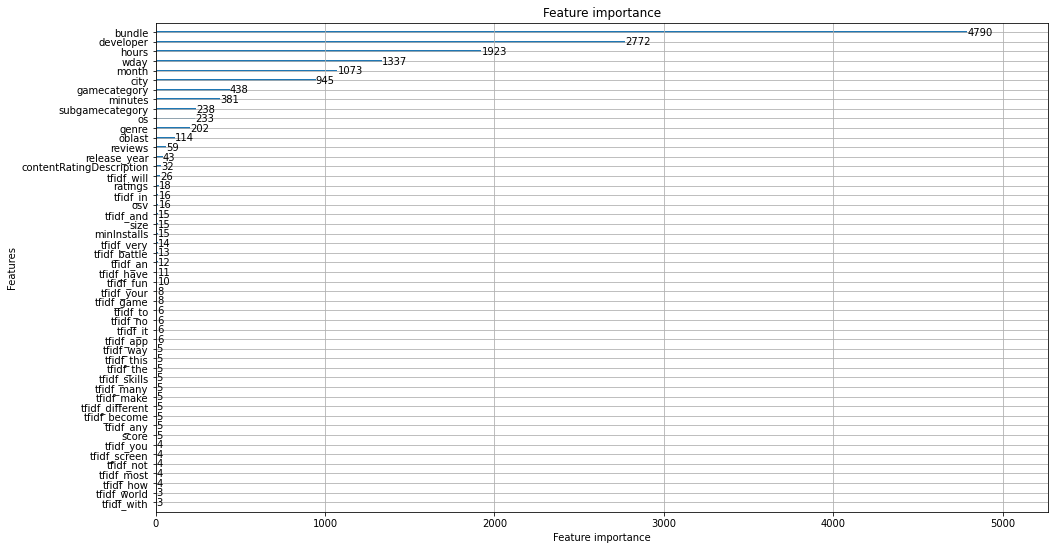

In [37]:
import lightgbm

lightgbm.plot_importance(lgb, max_num_features=50, figsize=(16,9))
plt.show()

# Прогноз на тестовую выборку

In [8]:
test = pd.read_csv('../data/test_preproc.csv')

test.drop(columns=['created', 'day'], inplace=True)

print(test.shape)
test.head()

(11213629, 14)


,gamecategory,subgamecategory,bundle,shift,oblast,city,os,osv,wday,month,minutes,hours,is_month_start,is_month_end
0,Applications,Shopping,com.allgoritm.youla,MSK+2,Свердловская область,Екатеринбург,android,10,6,9,31,17,False,False
1,NaN,NaN,com.ChocochocoStd.RapBattle,MSK+2,Ямало-Ненецкий АО,Новый Уренгой,android,10,1,8,13,17,False,False
2,NaN,NaN,1387897651,MSK,Москва,Москва,ios,14,4,9,54,15,False,False
3,NaN,NaN,com.cooking.family.diary.fever.food.city.craze...,MSK,Краснодарский край,Краснодар,android,9,0,7,34,23,False,False
4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,MSK,Татарстан,Набережные Челны,android,10,3,7,15,15,False,False


In [9]:
test = test.merge(google_features, on='bundle', how='left')

print(test.shape)
test.head()

(11213629, 161)


,gamecategory,subgamecategory,bundle,shift,oblast,city,os,osv,wday,month,minutes,hours,is_month_start,is_month_end,minInstalls,score,ratings,reviews,price,free,size,androidVersion,developer,genre,contentRating,contentRatingDescription,adSupported,containsAds,editorsChoice,moreByDeveloper,release_day,release_month,release_year,tfidf_2021,tfidf_3d,tfidf_adventure,tfidf_all,tfidf_also,tfidf_amazing,tfidf_an,tfidf_and,tfidf_android,tfidf_any,tfidf_app,tfidf_application,tfidf_are,tfidf_as,tfidf_at,tfidf_battle,tfidf_be,tfidf_beautiful,tfidf_become,tfidf_best,tfidf_but,tfidf_by,tfidf_can,tfidf_car,tfidf_choose,tfidf_city,tfidf_com,tfidf_create,tfidf_different,tfidf_do,tfidf_download,tfidf_drive,tfidf_driving,tfidf_each,tfidf_easy,tfidf_enjoy,tfidf_experience,tfidf_features,tfidf_find,tfidf_for,tfidf_free,tfidf_friends,tfidf_from,tfidf_fun,tfidf_game,tfidf_games,tfidf_get,tfidf_has,tfidf_have,tfidf_help,tfidf_high,tfidf_how,tfidf_if,tfidf_in,tfidf_into,tfidf_is,tfidf_it,tfidf_just,tfidf_level,tfidf_levels,tfidf_like,tfidf_love,tfidf_make,tfidf_many,tfidf_mode,tfidf_more,tfidf_most,tfidf_music,tfidf_need,tfidf_new,tfidf_no,tfidf_not,tfidf_now,tfidf_of,tfidf_offline,tfidf_on,tfidf_one,tfidf_only,tfidf_or,tfidf_other,tfidf_our,tfidf_out,tfidf_own,tfidf_phone,tfidf_photo,tfidf_play,tfidf_police,tfidf_puzzle,tfidf_racing,tfidf_real,tfidf_realistic,tfidf_robot,tfidf_screen,tfidf_shooting,tfidf_simple,tfidf_simulator,tfidf_skills,tfidf_so,tfidf_start,tfidf_take,tfidf_that,tfidf_the,tfidf_their,tfidf_them,tfidf_there,tfidf_this,tfidf_time,tfidf_to,tfidf_truck,tfidf_try,tfidf_unique,tfidf_up,tfidf_us,tfidf_use,tfidf_very,tfidf_video,tfidf_wallpaper,tfidf_wallpapers,tfidf_want,tfidf_way,tfidf_we,tfidf_when,tfidf_which,tfidf_will,tfidf_with,tfidf_world,tfidf_you,tfidf_your
0,Applications,Shopping,com.allgoritm.youla,MSK+2,Свердловская область,Екатеринбург,android,10,6,9,31,17,False,False,50000000.0,4.567825,2236447.0,792333.0,0.0,1.0,1.0,1.0,VK.com,Shopping,Rated for 12+,Parental Guidance Recommended,1.0,1.0,0.0,5.0,15.0,10.0,2015.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaN,NaN,com.ChocochocoStd.RapBattle,MSK+2,Ямало-Ненецкий АО,Новый Уренгой,android,10,1,8,13,17,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1387897651,MSK,Москва,Москва,ios,14,4,9,54,15,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [10]:
# преобразуем тип категориального признака
for cat_feature in ['gamecategory', 'subgamecategory', 'bundle', 'shift', 'oblast', 'city', 'developer', 'genre', 'contentRating', 'contentRatingDescription']:
    test[cat_feature] = test[cat_feature].astype('category')

In [11]:
test['os'] = test['os'].replace({'android': 0, 'ios': 1})

In [ ]:
#test.to_csv('./data/test_to_predict.csv', index=False)

In [18]:
# Будем делать предикт батчами, чтобы уместиться в память (не забыть про хвост, который потерялся при округлении)
header = True
for index_iter in range(500_000, len(test), 500_000):
    test_predictions = lgb.predict_proba(test[index_iter - 500_000:index_iter])

    test_predictions_df = pd.DataFrame(test_predictions, columns=lgb.classes_)
    test_predictions_df.to_csv('result.csv', mode='a', index=False, header=header)
    header = False